# BLS signal from single layer modeling
This example shows how SpinWaveToolkit (SWT) can be used to calculate the expected BLS signal of a single magnetic layer. 

We start by impoting the modules we need and by defining the parameters of the system and model.

In [2]:
# Import modules
import numpy as np
import SpinWaveToolkit as SWT
from matplotlib import pyplot as plt

In [ ]:
# Define parameters 
Bext = 50e-3         # External field [T]
theta = np.pi / 2    # Out-of-plane angle (fixed)
d_layer = 30e-9     # Magnetic layer thickness [m]
material = SWT.NiFe  # Material (from toolkit)
Nf_common = 51     # Number of frequency points for Bloch function

# Define the Kx,Ky grid limits and resolution.
Nk = 100             # resolution in Kx and Ky
k_min = 1e-6         # minimum k (avoid zero if necessary)
k_max = 15e6        # maximum k (as in original kxi range)
NA=0.75           # Numerical Aperture (NA) for the lens

# Create a regular Kx,Ky grid
kx_grid = np.linspace(-k_max, k_max, Nk)
ky_grid = np.linspace(-k_max, k_max, Nk)
KX, KY = np.meshgrid(kx_grid, ky_grid, indexing='ij')

Now we calculate the electric field incident on the magnetic layer using the `ObjectiveLens` class, get the Bloch functions in 3D and compute the BLS signal using the `getBLSsignal` function.

In [ ]:
# Now Bloch2D is an array of shape (Nf_common, Nk, Nk), where for each frequency,
# you have the Bloch amplitude defined on the Kx,Ky grid.
print("Preparing focal field...")
objective = SWT.ObjectiveLens(NA=NA, wavelength=532e-9, f0=10, f=1e-3)
x, y, Ex, Ey, Ez = objective.getFocalField(z=0, rho_max=10e-6, N=400)
E = [Ex, Ey, Ez]
Exy = [x, y]


# Preallocate the output array for the Bloch function amplitudes.
# The result will be complex amplitudes defined on a common frequency axis.
# Shape: (Nf_common, Nk, Nk)
Bloch2D = np.zeros((Nf_common, Nk, Nk), dtype=complex)

# We will also store the common frequency axis.
w_common = np.linspace(2*np.pi*3e9, 2*np.pi*18e9, Nf_common)

print("Preparing Bloch functions in 3D (f,kx,ky) using Slavin-Kalinikos model...")
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Compute polar coordinates for the current (KX, KY) point.
        kxi_val = np.sqrt(KX[i, j]**2 + KY[i, j]**2)
        # For a nearly zero radius, set phi = 0 (or any default value) to avoid NaN.
        phi_val = np.arctan2(KY[i, j], KX[i, j]) if kxi_val > 1e-12 else 0.0

        # Create a SingleLayer model for the current kxi and phi.
        # Note: We pass kxi as a one-element array.
        model = SWT.SingleLayer(Bext=Bext, kxi=np.array([kxi_val]),
                                theta=theta, phi=phi_val,
                                d=d_layer, material=material)
        # Compute the Bloch functions for n=0,1,2.
        # The returned w has shape (Nf_common,) and bf has shape (Nf_common, len(kxi))
        w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
        w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
        w2, bf2 = model.GetBlochFunction(n=2, Nf=Nf_common)
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, 0], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf0[:, 0], left=0, right=0)
        bf2_interp = np.interp(w_common, w2, bf0[:, 0], left=0, right=0)

        # Sum Bloch functions for n=0,1,2
        Bloch2D[:, i, j] = bf0_interp + bf1_interp + bf2_interp


Bloch3 = [Bloch2D, np.zeros((Nf_common, Nk, Nk), dtype=complex), Bloch2D*1j]


print("Computing BLS signal from Slavin-Kalinikos model...")
# Compute the BLS signal using the Bloch functions and the electric field.
Ex, Ey = SWT.getBLSsignal(SweepBloch=w_common, KxKyBloch=[kx_grid, ky_grid], Bloch=np.array(Bloch3),
                          Exy=Exy, E=E, Nq=50, DF=[1, -8.1653 + 1j*15.348, 17.237 + 1j*0.43004],
                          PM=[1,1,1], d=[d_layer], NA=NA, source_layer_index=1, output_layer_index=0,
                          wavelength=532e-9, collectionSpot=0.5e-6, focalLength=1e-3)

Preparing focal field...
Preparing Bloch functions in 3D (f,kx,ky) using Slavin-Kalinikos model...
Computing BLS signal from Slavin-Kalinikos model...


Finally, we plot the resulting BLS signal.

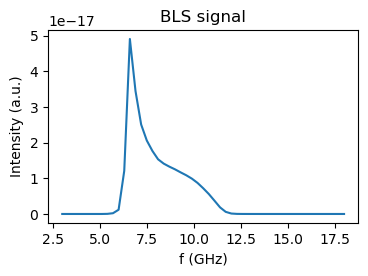

In [5]:
# Plot the BLS signal
plt.figure(figsize=(4, 2.5))
plt.plot(w_common/2/np.pi/1e9, np.abs(Ey*np.conj(Ey)), label='Slavin-Kalinikos model')
plt.xlabel('frequency (GHz)')
plt.ylabel('BLS intensity (a.u.)')
plt.title('BLS signal')
plt.show()